In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score


In [3]:
# Update the input shape and other parameters
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
# Class names
class_names = dataset.class_names


In [6]:
# Split dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [7]:
#Optimize dataset performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [8]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])


In [9]:
# Preprocessing layer for DenseNet201
preprocess_input = applications.densenet.preprocess_input/-

In [10]:
# Build the model
base_model = applications.DenseNet201(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                                      include_top=False,
                                      weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [11]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
)

Epoch 1/50
54/54 [==============================] - 189s 3s/step - loss: 1.0974 - accuracy: 0.7928 - val_loss: 0.1810 - val_accuracy: 0.9219
Epoch 2/50
54/54 [==============================] - 171s 3s/step - loss: 0.2324 - accuracy: 0.9109 - val_loss: 0.1410 - val_accuracy: 0.9323
Epoch 3/50
54/54 [==============================] - 169s 3s/step - loss: 0.1880 - accuracy: 0.9306 - val_loss: 0.1059 - val_accuracy: 0.9427
Epoch 4/50
54/54 [==============================] - 172s 3s/step - loss: 0.1474 - accuracy: 0.9485 - val_loss: 0.1171 - val_accuracy: 0.9583
Epoch 5/50
54/54 [==============================] - 172s 3s/step - loss: 0.1273 - accuracy: 0.9543 - val_loss: 0.0620 - val_accuracy: 0.9844
Epoch 6/50
54/54 [==============================] - 170s 3s/step - loss: 0.1141 - accuracy: 0.9537 - val_loss: 0.0634 - val_accuracy: 0.9792
Epoch 7/50
54/54 [==============================] - 170s 3s/step - loss: 0.0959 - accuracy: 0.9647 - val_loss: 0.0370 - val_accuracy: 0.9896
Epoch 8/50
54

In [12]:
# Evaluate the model
scores = model.evaluate(test_ds)


8/8 [==============================] - 23s 3s/step - loss: 0.0372 - accuracy: 0.9961


In [13]:
# Get predictions
def get_predictions(model, test_ds):
    predictions = []
    true_labels = []
    for images_batch, labels_batch in test_ds:
        batch_prediction = model.predict(images_batch)
        predictions.extend(np.argmax(batch_prediction, axis=1))
        true_labels.extend(labels_batch.numpy())
    return np.array(predictions), np.array(true_labels)

predictions, true_labels = get_predictions(model, test_ds)


1/1 [==============================] - 3s 3s/step


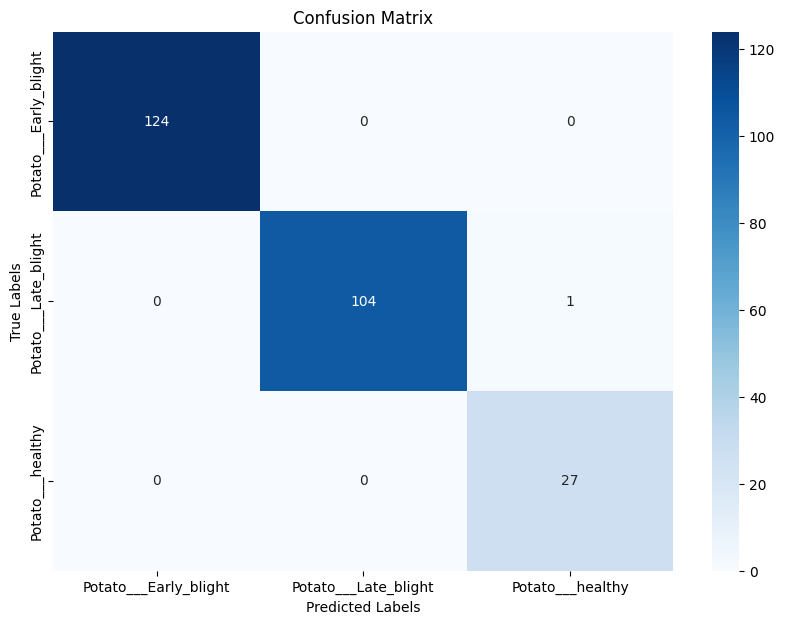

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [15]:
# Classification Report
class_report = classification_report(true_labels, predictions, target_names=class_names)
print("\nClassification Report:")
print(class_report)



Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00       124
 Potato___Late_blight       1.00      0.99      1.00       105
     Potato___healthy       0.96      1.00      0.98        27

             accuracy                           1.00       256
            macro avg       0.99      1.00      0.99       256
         weighted avg       1.00      1.00      1.00       256



In [16]:
# Metrics
precision = precision_score(true_labels, predictions, average=None)
recall = recall_score(true_labels, predictions, average=None)
f1 = f1_score(true_labels, predictions, average=None)
accuracy = accuracy_score(true_labels, predictions)

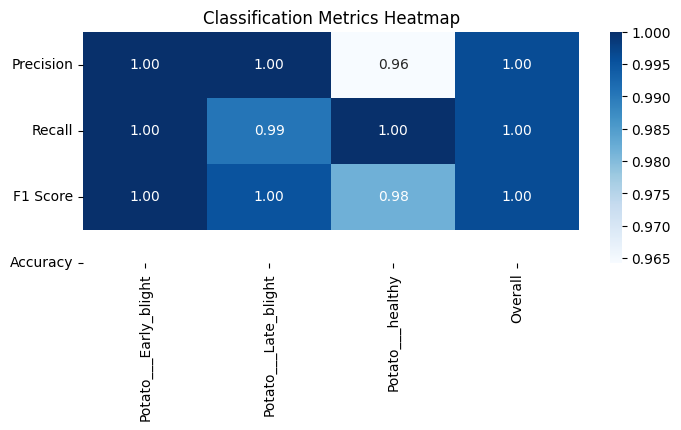

In [17]:
# Metrics Matrix
metrics_matrix = np.array([precision, recall, f1])
accuracy_column = np.full((metrics_matrix.shape[0], 1), accuracy)
metrics_matrix = np.hstack((metrics_matrix, accuracy_column))

metrics_labels = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
plt.figure(figsize=(8, 3))
sns.heatmap(metrics_matrix, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names + ['Overall'], yticklabels=metrics_labels)
plt.title('Classification Metrics Heatmap')
plt.yticks(rotation=0)
plt.show()

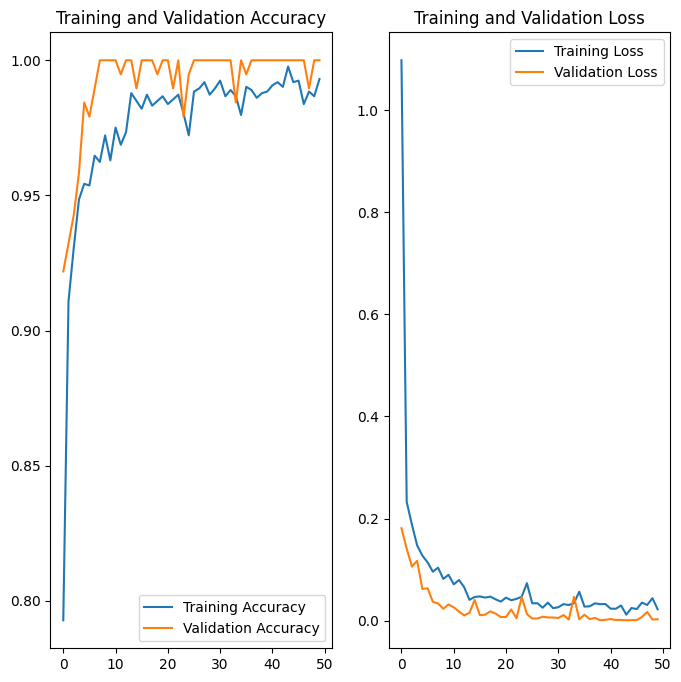

In [18]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 [==============================] - 0s 124ms/step


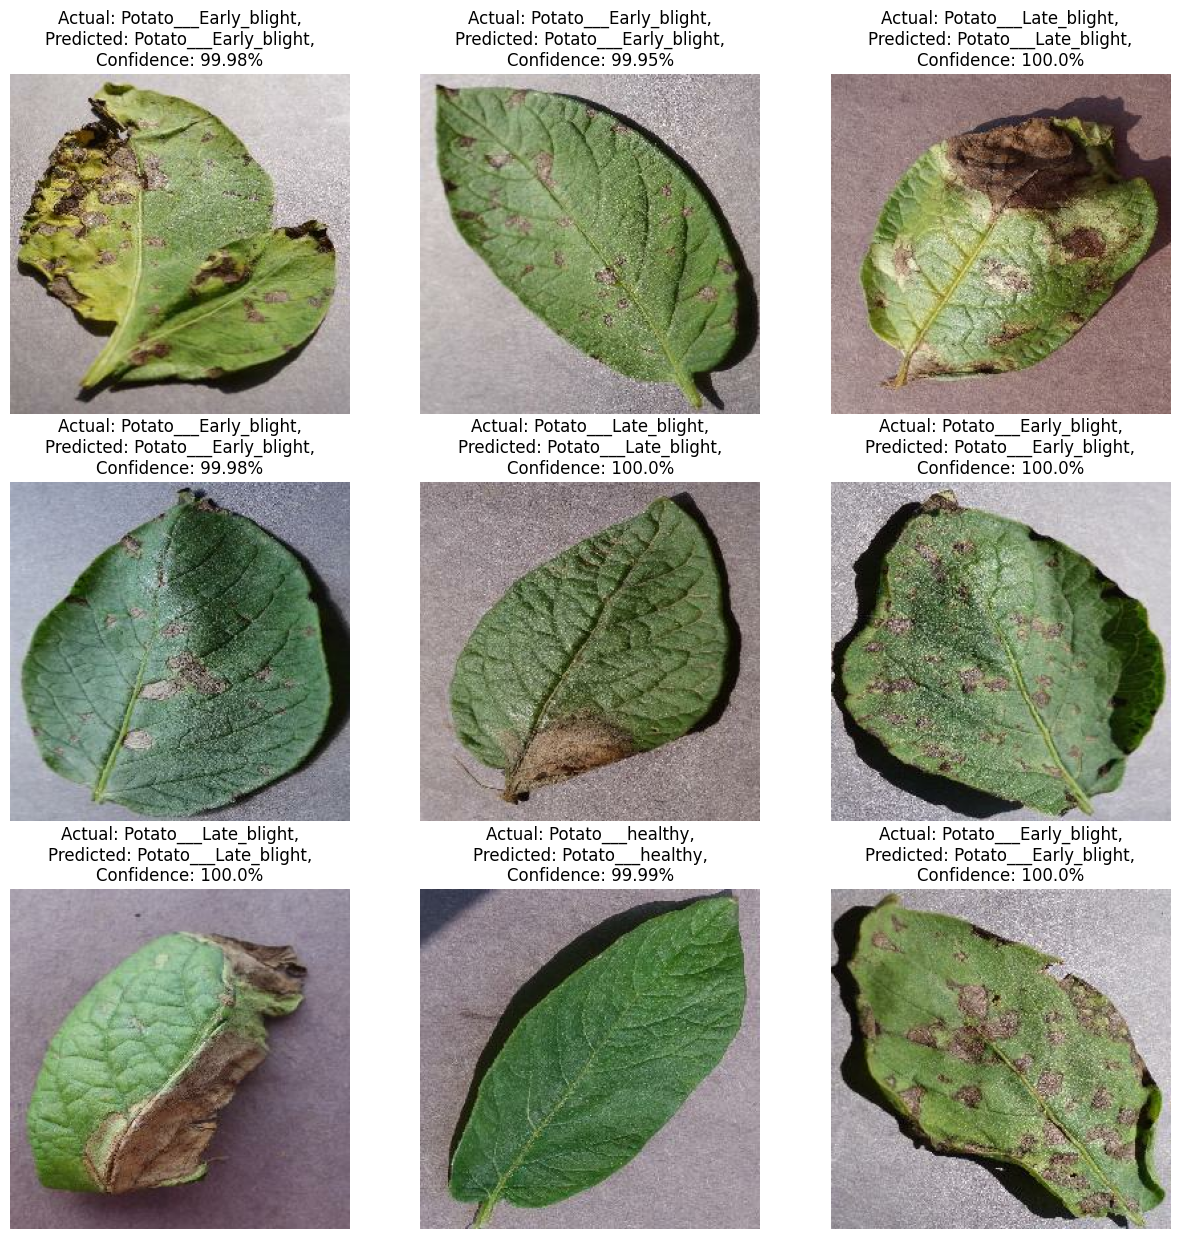

In [19]:
# Predict a single image
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")
        plt.axis("off")
plt.show()